<a href="https://colab.research.google.com/github/hadilbelhadjhassin/gomycode/blob/main/Let's_plot_some_trees.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import sklearn.tree as tree
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn import metrics
from subprocess import call
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [2]:
titanic=pd.read_csv('TitanicDataSet.csv')

In [3]:
grouped=titanic.groupby(['Sex', 'Pclass'])
def cleaning(group):
    return group.fillna(group.mean())
titanic['Age']=grouped['Age'].transform(cleaning)

In [4]:
print(titanic['Embarked'].value_counts())
titanic['Embarked']=titanic['Embarked'].fillna('S')

S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [5]:
titanic.drop(['PassengerId', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [6]:
#Adding column with information about family size
titanic['FamilySize']= titanic['SibSp']+titanic['Parch']+1

In [7]:
titanic['IsAlone']=1
titanic['IsAlone'].loc[titanic['FamilySize']>1]=0

In [8]:
titanic['Title']=titanic['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
titanic['Title'].replace({'Ms':'Miss', 'Mlle':'Miss', 'Mme':'Mrs'}, inplace=True)
titanic['Title'].replace(['Dr', 'Rev', 'Col', 'Major', 'Jonkheer', 'Countess', 'Lady', 'Don', 'Capt', 'Sir'], 'Special', inplace=True)

In [9]:
titanic['GroupAge']=pd.cut(titanic['Age'], 4, labels=False)

In [10]:
titanic['GroupFare']=pd.qcut(titanic['Fare'],4, labels=False)

In [11]:
titanic.drop(['FamilySize', 'Name', 'Age', 'SibSp', 'Parch', 'Fare'], axis=1, inplace=True)

In [12]:
titanic=pd.get_dummies(titanic, columns=['Pclass', 'Sex', 'Embarked', 'Title'], drop_first=True)

In [13]:
X=titanic.drop('Survived', axis=1)
y=titanic['Survived']

In [14]:
X_train, X_test, y_train, y_test=train_test_split(X,y, test_size=0.2, random_state=42)

In [16]:
def prediction_auc(X, y_true):
    y_pred=decisiontree.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
    result = auc(false_positive_rate, true_positive_rate)
    return result


In [17]:
def plotting(x, x_name, list_auc_train, list_auc_test):
    plt.plot(x, list_auc_train, label='train')    
    plt.plot(x, list_auc_test, label='test')
    plt.legend()
    plt.xlabel(x_name)
    plt.ylabel('AUC score')
    plt.show()

In [18]:
def visualizing_tree(tree, name):
    export_graphviz(tree, out_file='tree.dot',feature_names = X_train.columns.tolist(), class_names=['Not Survived', 'Survived'], rounded = True, proportion = False, precision = 2, filled = True)
    call(['dot', '-Tpng', 'tree.dot', '-o', name, '-Gdpi=600'])
    return Image(filename = name)

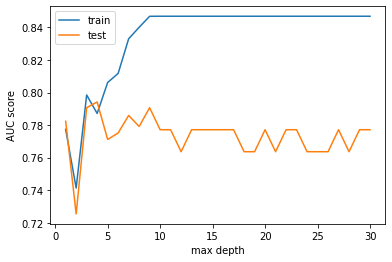

In [19]:
max_depths=range(1,31) #creating list of values to check

list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of max depth
for max_depth in max_depths:
    decisiontree=DecisionTreeClassifier(max_depth=max_depth)
    decisiontree.fit(X_train,y_train)
    
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(max_depths, 'max depth', list_auc_train, list_auc_test)

In [20]:
#buliding tree with max depth=4
decisiontree_depth_4=DecisionTreeClassifier(max_depth=4)
decisiontree_depth_4.fit(X_train,y_train)
y_pred=decisiontree_depth_4.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)

AUC score:  0.7942084942084942


In [21]:
#visualizing tree structure
visualizing_tree(decisiontree_depth_4, 'tree_depth_4.png')

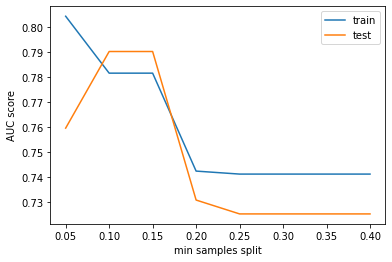

In [22]:
min_samples_splits=np.linspace(0.05,0.4,8) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples split
for min_samples_split in min_samples_splits:
    decisiontree=DecisionTreeClassifier(min_samples_split=min_samples_split)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_splits, 'min samples split', list_auc_train, list_auc_test)

In [23]:
#building tree with min samples split=0.1 and visualizing its structure
decisiontree_split_01=DecisionTreeClassifier(min_samples_split=0.1)
decisiontree_split_01.fit(X_train,y_train)
y_pred=decisiontree_split_01.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
visualizing_tree(decisiontree_split_01, 'tree_split_01.png')

AUC score:  0.7902187902187902


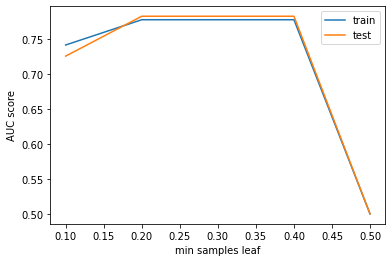

In [24]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True) #creating list of values to check
list_auc_train=[] #list to store results for train dataset 
list_auc_test=[] #list to store results for test dataset

#creating model and check result for each value of min samples leaf
for min_samples_leaf in min_samples_leafs:
    decisiontree=DecisionTreeClassifier(min_samples_leaf=min_samples_leaf)
    decisiontree.fit(X_train,y_train)
    auc_train=prediction_auc(X_train,y_train)
    list_auc_train.append(auc_train)
    
    auc_test=prediction_auc(X_test,y_test)
    list_auc_test.append(auc_test)

#plotting results    
plotting(min_samples_leafs, 'min samples leaf', list_auc_train, list_auc_test)

AUC score:  0.7823680823680824


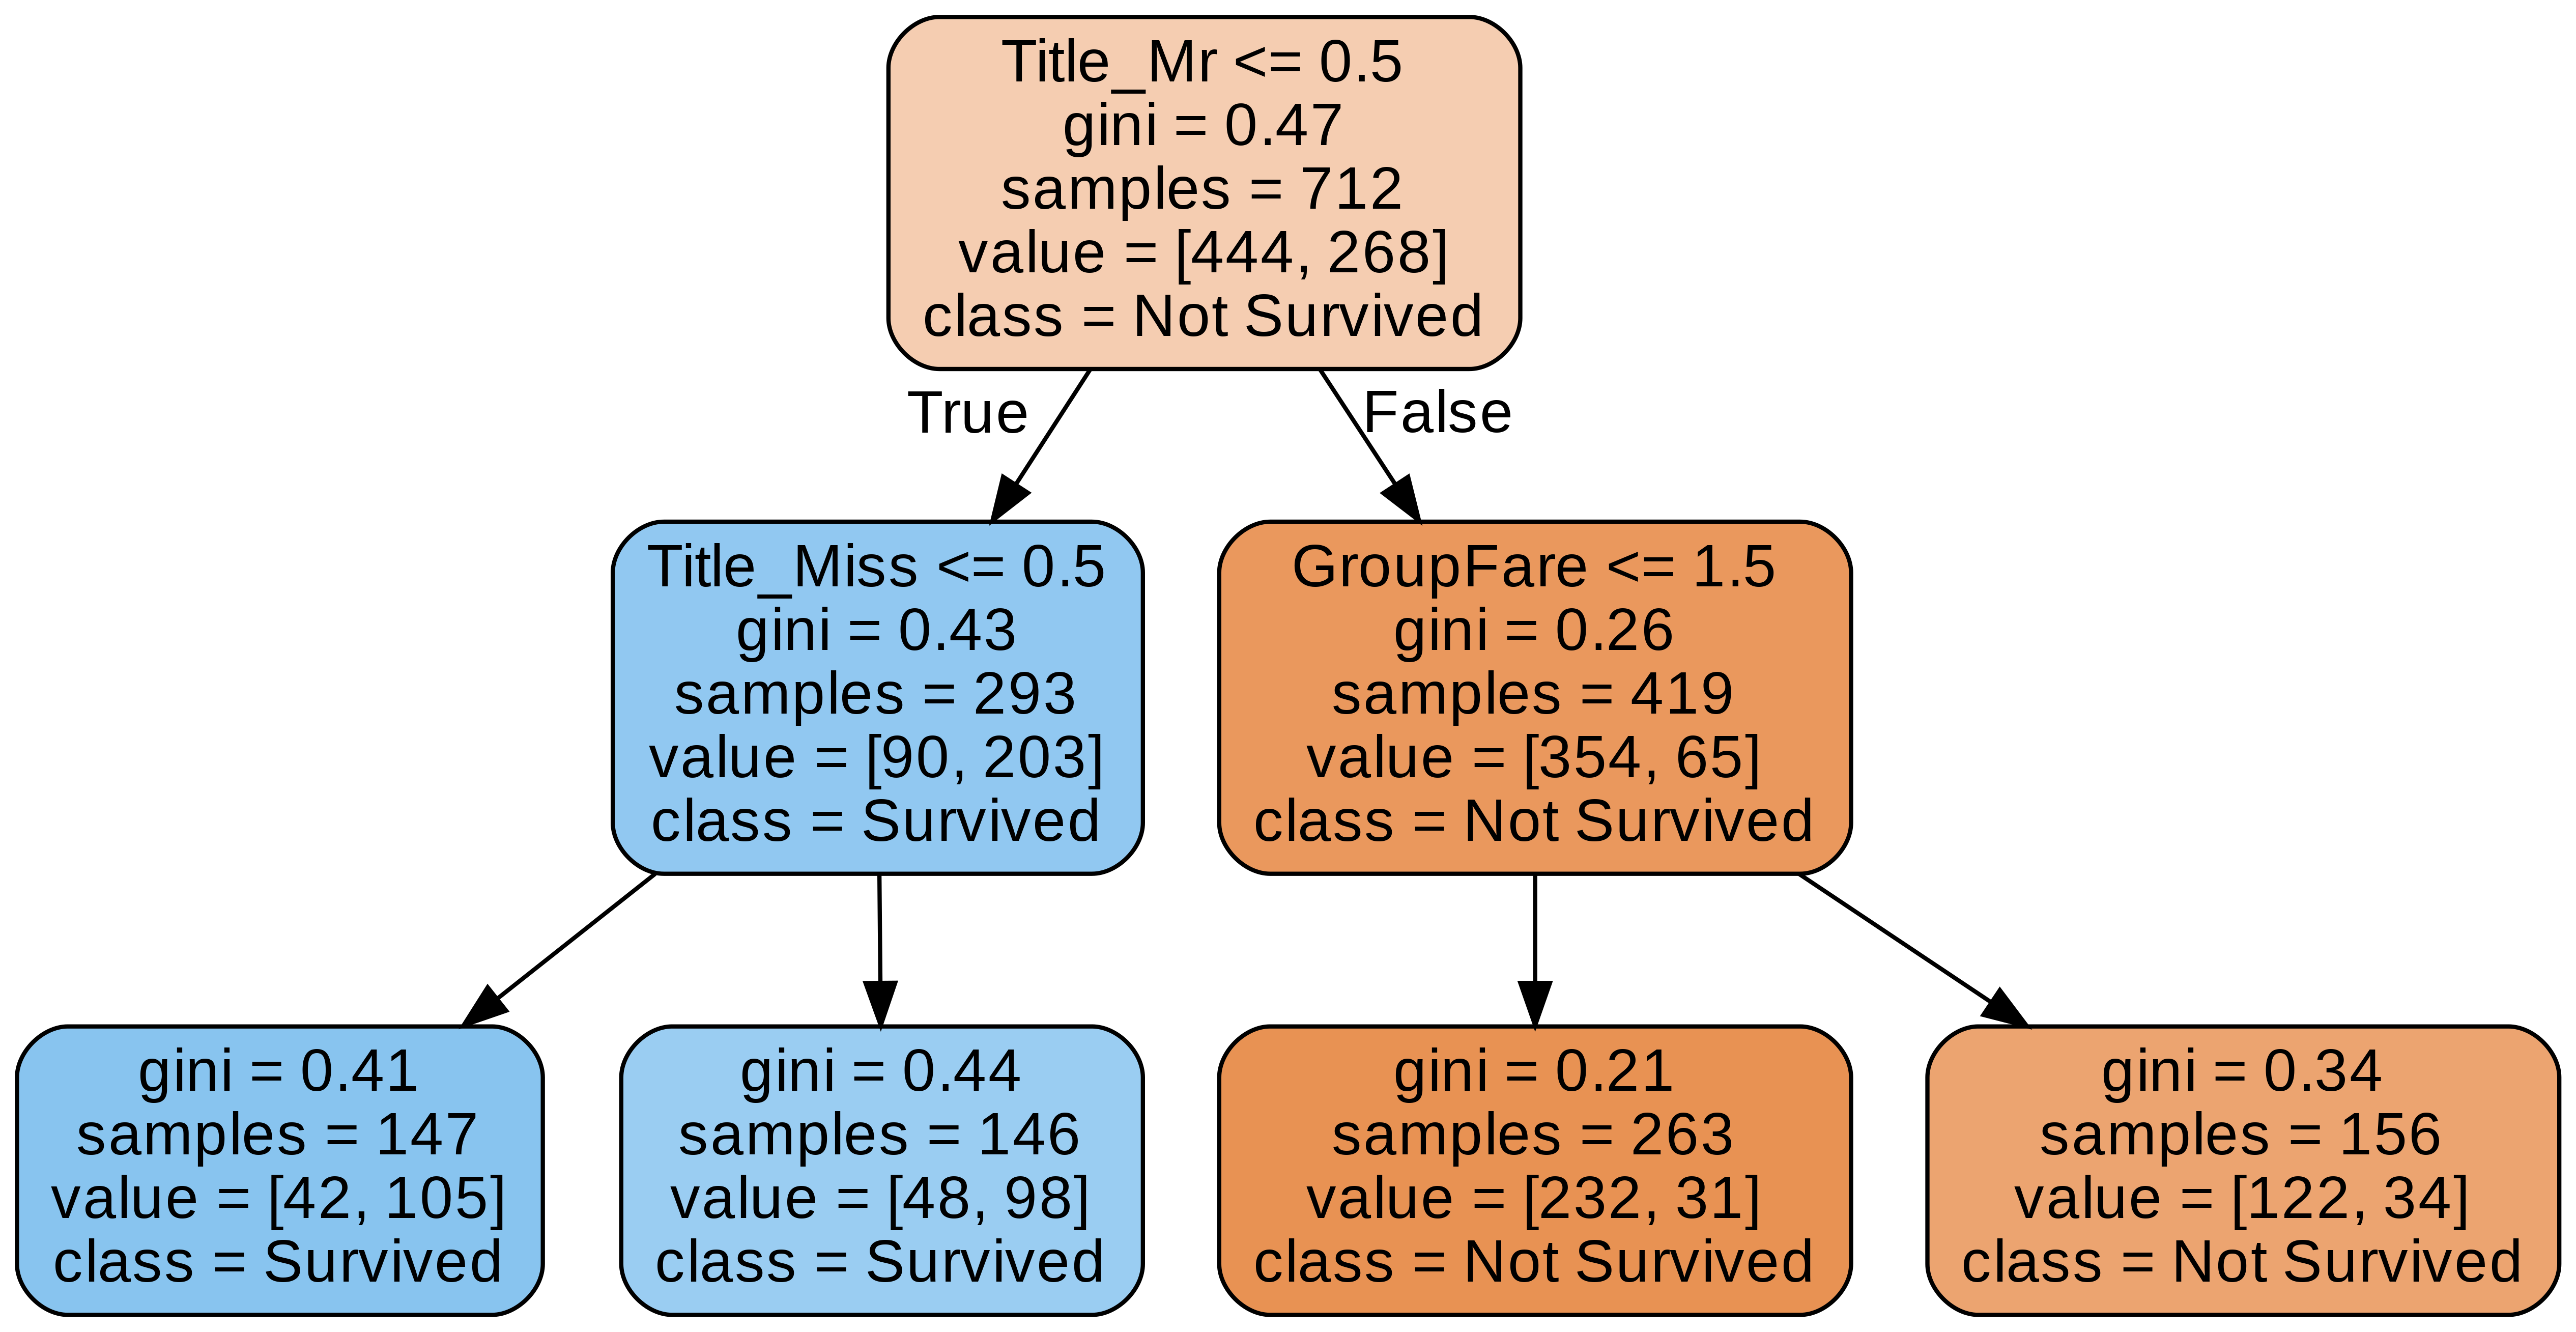

In [25]:
#building tree with min samples leaf=0.2 and visualizing its structure
decisiontree_leaf_02=DecisionTreeClassifier(min_samples_leaf=0.2)
decisiontree_leaf_02.fit(X_train,y_train)
y_pred=decisiontree_leaf_02.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
result = auc(false_positive_rate, true_positive_rate)
print('AUC score: ', result)
visualizing_tree(decisiontree_leaf_02, 'tree_leaf_02.png')

In [26]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 19}


In [27]:
#Random Forest
randomforest=RandomForestClassifier() #initializing model
ne = np.arange(1,20) 
param_grid = {'n_estimators' : ne} #parameters grid

rf_cv = GridSearchCV(randomforest, param_grid=param_grid, cv=5) #performing gridsearchcv
rf_cv.fit(X, y)
print('Best estimator', rf_cv.best_params_)

Best estimator {'n_estimators': 11}
